In [1]:
# import libraries
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import talib
import seaborn as sns
import statsmodels.api as sm
import numpy as np


c:\Users\el1trm\Documents\GitHub\Stock-Price-Prediction\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download latest version of yahoo stock price dataset from Kaggle
path = kagglehub.dataset_download("arashnic/time-series-forecasting-with-yahoo-stock-price")
print("Path to dataset files:", path)
yahoo = pd.read_csv(path + "/yahoo_stock.csv")
yahoo['Date'] = pd.to_datetime(yahoo['Date'])
print(yahoo.head())

Path to dataset files: C:\Users\el1trm\.cache\kagglehub\datasets\arashnic\time-series-forecasting-with-yahoo-stock-price\versions\3
        Date         High          Low         Open        Close  \
0 2015-11-23  2095.610107  2081.389893  2089.409912  2086.590088   
1 2015-11-24  2094.120117  2070.290039  2084.419922  2089.139893   
2 2015-11-25  2093.000000  2086.300049  2089.300049  2088.870117   
3 2015-11-26  2093.000000  2086.300049  2089.300049  2088.870117   
4 2015-11-27  2093.290039  2084.129883  2088.820068  2090.110107   

         Volume    Adj Close  
0  3.587980e+09  2086.590088  
1  3.884930e+09  2089.139893  
2  2.852940e+09  2088.870117  
3  2.852940e+09  2088.870117  
4  1.466840e+09  2090.110107  


Look at the data

<Axes: >

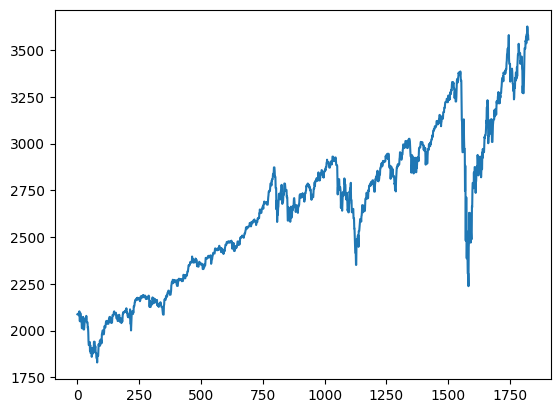

In [3]:
yahoo['Adj Close'].plot()

<Axes: >

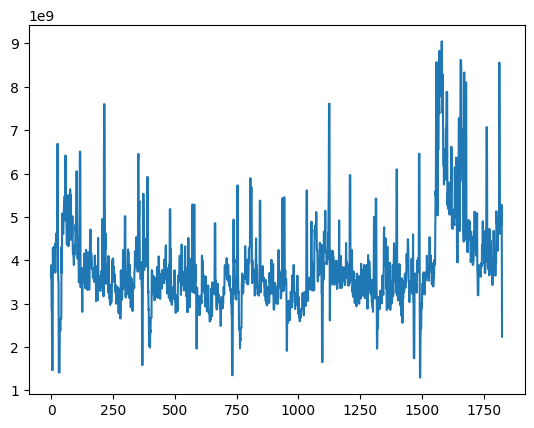

In [4]:
yahoo['Volume'].plot()

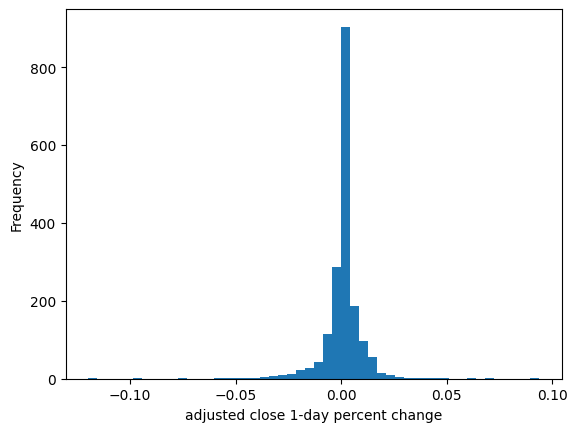

In [5]:
yahoo['Adj Close'].pct_change().plot.hist(bins=50)
plt.xlabel('adjusted close 1-day percent change')
plt.show()

In [6]:
yahoo['10d_future_close'] = yahoo['Adj Close'].shift(-10)
yahoo['10d_future_close_pct'] = yahoo['10d_future_close'].pct_change(10)
yahoo['10d_close_pct'] = yahoo['Adj Close'].pct_change(10)

print('Lenght of the dataset:', len(yahoo))
print(yahoo.head())

# calculate the correlation matrix between the 5d close percentage changes (current and future)
corr = yahoo[['10d_close_pct', '10d_future_close_pct']].corr()
print(corr)


Lenght of the dataset: 1825
        Date         High          Low         Open        Close  \
0 2015-11-23  2095.610107  2081.389893  2089.409912  2086.590088   
1 2015-11-24  2094.120117  2070.290039  2084.419922  2089.139893   
2 2015-11-25  2093.000000  2086.300049  2089.300049  2088.870117   
3 2015-11-26  2093.000000  2086.300049  2089.300049  2088.870117   
4 2015-11-27  2093.290039  2084.129883  2088.820068  2090.110107   

         Volume    Adj Close  10d_future_close  10d_future_close_pct  \
0  3.587980e+09  2086.590088       2049.620117                   NaN   
1  3.884930e+09  2089.139893       2091.689941                   NaN   
2  2.852940e+09  2088.870117       2091.689941                   NaN   
3  2.852940e+09  2088.870117       2091.689941                   NaN   
4  1.466840e+09  2090.110107       2077.070068                   NaN   

   10d_close_pct  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  
                

C:\Users\el1trm\AppData\Local\Temp\ipykernel_24732\577908610.py:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  yahoo['10d_future_close_pct'] = yahoo['10d_future_close'].pct_change(10)


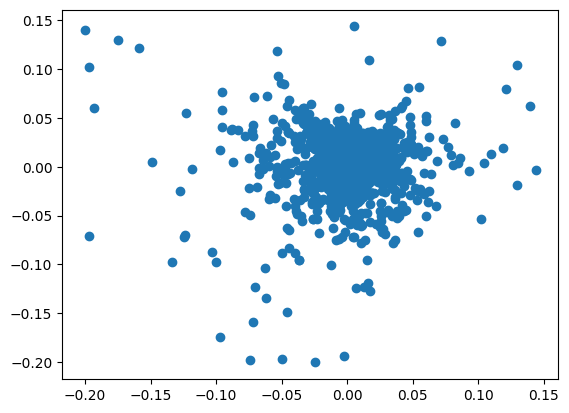

In [7]:
# scatter the current 10-day percent change vs the future 10-day percent change
plt.scatter(yahoo['10d_close_pct'], yahoo['10d_future_close_pct'])
plt.show()

Prepare data for ML

In [8]:
features = yahoo[['10d_close_pct', 'Adj Close', 'Volume']]
# our targets are the future price changes
targets = yahoo['10d_future_close_pct']

yahoo['ma14'] = talib.SMA(yahoo['Adj Close'].values, timeperiod=14)
yahoo['rsi14'] = talib.RSI(yahoo['Adj Close'].values, timeperiod=14)

yahoo['ma30'] = talib.SMA(yahoo['Adj Close'].values, timeperiod=30)
yahoo['rsi30'] = talib.RSI(yahoo['Adj Close'].values, timeperiod=30)

yahoo['ma50'] = talib.SMA(yahoo['Adj Close'].values, timeperiod=50)
yahoo['rsi50'] = talib.RSI(yahoo['Adj Close'].values, timeperiod=50)


yahoo['ma200'] = talib.SMA(yahoo['Adj Close'].values, timeperiod=200)
yahoo['rsi200'] = talib.RSI(yahoo['Adj Close'].values, timeperiod=200)

#plt the adj close price against the 200 day moving average
plt.plot(yahoo['Date'], yahoo['ma200'], label='MA200', linewidth=1.5)
plt.plot(yahoo['Date'], yahoo['Adj Close'], label='Adj Close', linewidth=1.5)

# Format x-axis ticks to show years only
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())

# Add labels, title, and legend
plt.title('MA200 and Adj Close Over Time')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# drop na rows - ML can't handle them
yahoo = yahoo.dropna()

feature_names = ['10d_close_pct', 'ma14', 'rsi14', 'ma30', 'rsi30', 'ma50', 'rsi50', 'ma200', 'rsi200']
features = yahoo[feature_names]
print(features.head()) 10d_close_pcttarge

targets = yahoo['10d_future_close_pct']

feature_target_df = yahoo[feature_names + ['10d_future_close_pct']]

corr = feature_target_df.corr()
sns.heatmap(corr, annot=True)

     10d_close_pct         ma14      rsi14         ma30      rsi30  \
200      -0.000420  2103.451416  53.117126  2080.485343  55.383448   
201      -0.001553  2103.237845  53.117126  2081.550675  55.383448   
202      -0.004365  2103.024275  53.117126  2083.199345  55.383448   
203      -0.009561  2101.595703  42.954849  2084.281014  50.753631   
204      -0.011343  2100.050711  41.093286  2085.238017  49.806609   

            ma50      rsi50        ma200     rsi200  
200  2077.223203  54.847854  2016.125801  50.234442  
201  2077.313003  54.847854  2016.160452  50.234442  
202  2077.402803  54.847854  2016.196452  50.234442  
203  2077.152402  52.365220  2016.147402  49.809038  
204  2076.903003  51.838782  2016.073452  49.716005  


<Axes: >

Linear Modeling with financial data

training data = earliest data
testing data = latest data

Can't use sklearn train-test-split as it randomly shuffles the dataset

In [10]:
# Add a constant to the features
# for linear models needs to add a constant to our features, which adds a columns of 1s for a y intercept term
linear_features = sm.add_constant(features)
print(linear_features.head())
print(linear_features.columns)

print(targets.shape[0])
train_size = int(0.85 * targets.shape[0])

train_features = linear_features[:train_size]
train_targets = targets[:train_size]
test_features = linear_features[train_size:]
test_targets = targets[train_size:]

     const  10d_close_pct         ma14      rsi14         ma30      rsi30  \
200    1.0      -0.000420  2103.451416  53.117126  2080.485343  55.383448   
201    1.0      -0.001553  2103.237845  53.117126  2081.550675  55.383448   
202    1.0      -0.004365  2103.024275  53.117126  2083.199345  55.383448   
203    1.0      -0.009561  2101.595703  42.954849  2084.281014  50.753631   
204    1.0      -0.011343  2100.050711  41.093286  2085.238017  49.806609   

            ma50      rsi50        ma200     rsi200  
200  2077.223203  54.847854  2016.125801  50.234442  
201  2077.313003  54.847854  2016.160452  50.234442  
202  2077.402803  54.847854  2016.196452  50.234442  
203  2077.152402  52.365220  2016.147402  49.809038  
204  2076.903003  51.838782  2016.073452  49.716005  
Index(['const', '10d_close_pct', 'ma14', 'rsi14', 'ma30', 'rsi30', 'ma50',
       'rsi50', 'ma200', 'rsi200'],
      dtype='object')
1615


In [11]:
# fit a linear model
model = sm.OLS(train_targets, train_features)
results = model.fit()
print(results.summary())

                             OLS Regression Results                             
Dep. Variable:     10d_future_close_pct   R-squared:                       0.109
Model:                              OLS   Adj. R-squared:                  0.103
Method:                   Least Squares   F-statistic:                     18.58
Date:                  Wed, 07 May 2025   Prob (F-statistic):           1.85e-29
Time:                          11:39:40   Log-Likelihood:                 3162.4
No. Observations:                  1372   AIC:                            -6305.
Df Residuals:                      1362   BIC:                            -6253.
Df Model:                             9                                         
Covariance Type:              nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0302  

In [12]:
# Features with p <= 0.05 are typically considered significantly different from 0
print(results.pvalues)

const            7.825733e-02
10d_close_pct    9.055948e-05
ma14             1.660892e-07
rsi14            9.480534e-02
ma30             1.697141e-03
rsi30            6.765483e-01
ma50             8.898587e-02
rsi50            3.982120e-01
ma200            1.457408e-05
rsi200           8.195478e-01
dtype: float64


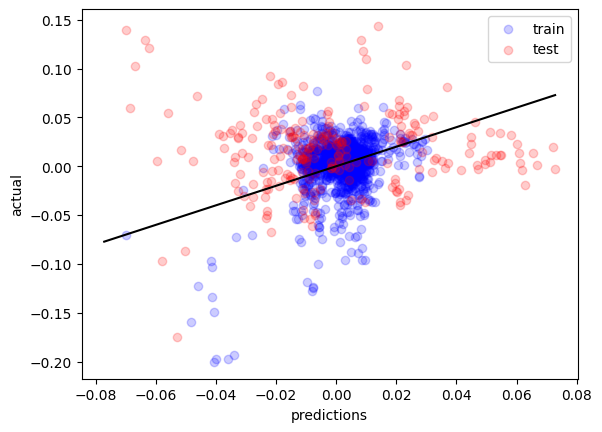

In [13]:
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)  

# Scatter the predictions vs the targets with 20% opacity
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.2, color='r', label='test') 

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()

linear model not the best... need to add feature interactions - to overcome the limitations of linear models - they can't work out non-liner relationships. interaction features are a way of adding a non-linear interaction term for a linear model

Combinations of features might add some predictive power - best to use models good at utilising these non-linear relationships: random forests, gradient boosting, neural networks

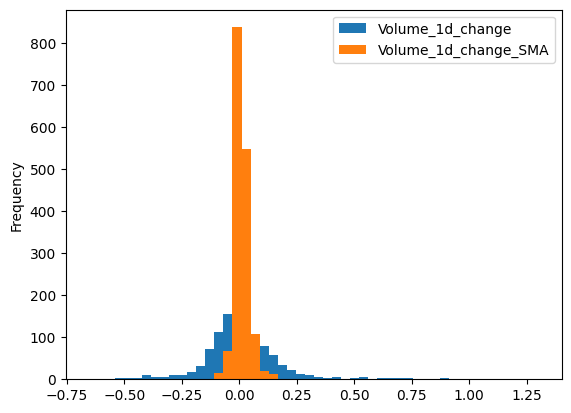

In [14]:
# volume feature engineering
new_features = ['Volume_1d_change', 'Volume_1d_change_SMA']
feature_names.extend(new_features)

yahoo['Volume_1d_change'] = yahoo['Volume'].pct_change()    
one_day_change = yahoo['Volume_1d_change'].values
yahoo['Volume_1d_change_SMA'] = talib.SMA(one_day_change, timeperiod=10)


# Plot histogram of volume % change data
yahoo[new_features].plot(kind='hist', sharex=False, bins = 50)
plt.show()

In [15]:
# datetime feature engineering - days of the week
#day of the week, also could use day of month, month, quarter, year

#set index to date
yahoo.index = yahoo['Date']
#print(yahoo.index.dayofweek)

# We can infer its a monday from all the other columns, except Monday - so drop the monday column as not neccessary (drop_frist=True)
days_of_week = pd.get_dummies(yahoo.index.dayofweek, prefix='weekday', drop_first=True)
# weekday_1 = Tuesday etc...

#set the index as the original dataframe index for merging
days_of_week.index = yahoo.index

# join the dataframe with the days of the week dataframe
yahoo = pd.concat([yahoo, days_of_week], axis=1)

# Add days of week to feature names
feature_names.extend(['weekday_' +str(i) for i in range(1, 5)])
yahoo.dropna(inplace=True)


#print(yahoo.head())
print(yahoo.columns)

Index(['Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close',
       '10d_future_close', '10d_future_close_pct', '10d_close_pct', 'ma14',
       'rsi14', 'ma30', 'rsi30', 'ma50', 'rsi50', 'ma200', 'rsi200',
       'Volume_1d_change', 'Volume_1d_change_SMA', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6'],
      dtype='object')


In [16]:
new_features.extend(['weekday_' + str(i) for i in range(1, 5)])

# plot the correlations between the new features and the targets
sns.heatmap(yahoo[new_features + ['10d_future_close_pct']].corr(), annot=True)

plt.yticks(rotation=0)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [17]:
# make new train and test and predict features and targets for the next models we are investigating
print(feature_names)

features = yahoo[feature_names]
targets = yahoo['10d_future_close_pct']

train_size = int(0.85 * targets.shape[0])

train_features = features[:train_size]
train_targets = targets[:train_size]
test_features = features[train_size:]
test_targets = targets[train_size:]


['10d_close_pct', 'ma14', 'rsi14', 'ma30', 'rsi30', 'ma50', 'rsi50', 'ma200', 'rsi200', 'Volume_1d_change', 'Volume_1d_change_SMA', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4']


# Decision Tree

In [18]:
import sklearn
from sklearn.tree import DecisionTreeRegressor

# default argument decision tree regressor
decision_tree = DecisionTreeRegressor()

# fit model to trainng features and targets
decision_tree.fit(train_features, train_targets)

#print(train_features.head())

# check the score on the train and test data
print('train score = ', decision_tree.score(train_features, train_targets))   
print('test score = ', decision_tree.score(test_features, test_targets))

train score =  1.0
test score =  -3.944878296715677


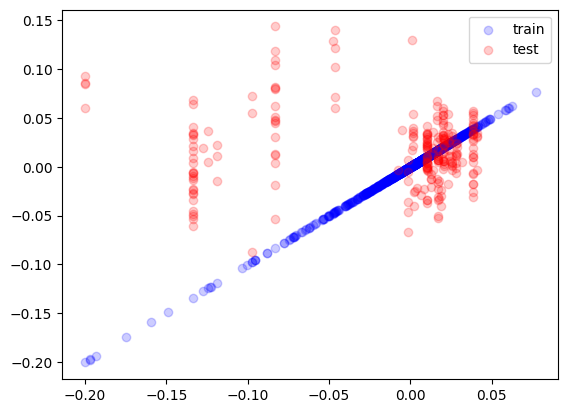

In [19]:
# above is r^2 values
# 1 is perfect, 0 is useless, negative is terrible

# so we terribly overfit 

# we can see this in a plot too
train_predictions = decision_tree.predict(train_features)
test_predictions = decision_tree.predict(test_features) 
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.2, color='r', label='test')
plt.legend()
plt.show()

In [20]:
# try different max depths

for d in [3, 5, 10]:
    # create the tree and fit it
    decision_tree = DecisionTreeRegressor(max_depth=d)
    decision_tree.fit(train_features, train_targets)
    
    #print the score on the train and test data
    print(f"max_depth={d}:")
    print("train score:", decision_tree.score(train_features, train_targets))
    print("test score:", decision_tree.score(test_features, test_targets))
    print(" ")
    

max_depth=3:
train score: 0.5002195222784509
test score: -3.50957988751178
 
max_depth=5:
train score: 0.5805265386427731
test score: -3.1396538582128226
 
max_depth=10:
train score: 0.8467052419161399
test score: -3.4424259136290223
 


In [21]:
# max_depth = 5 is best out of those options, so for not keep with that

decision_tree = DecisionTreeRegressor(max_depth=5)
decision_tree.fit(train_features, train_targets)

# predict values for train and test
train_predictions = decision_tree.predict(train_features)
test_predictions = decision_tree.predict(test_features)

# scatter the predictions vs actual values
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.2, color='r', label='test')
plt.show()

# Random Forests

In [22]:
# multiple decision trees and use bootstrapping to get datasets for each tree
# reduces variances and bias issue that crop up with decision trees

In [23]:
from sklearn.ensemble import RandomForestRegressor

# create a random forest regressor with 200 trees
rfr = RandomForestRegressor(n_estimators=200)
rfr.fit(train_features, train_targets)

# look at the R^2 scores on train and test
print("train score:", rfr.score(train_features, train_targets))
print("test score:", rfr.score(test_features, test_targets))

train score: 0.9804120453786953
test score: -2.991118554330763


In [24]:
# tune random forest hyperparameters
from sklearn.model_selection import ParameterGrid 

# creat dictionary of hyperparameters to search
grid = {'n_estimators':[200], 'max_depth': [3], 'max_features': [4, 8], 'random_state': [42]}
test_scores = []

# loop through the grid and fit a model for each combination of hyperparameters
for g in ParameterGrid(grid):
    rfr.set_params(**g)  # ** is "unpacking" the dictionary
    rfr.fit(train_features, train_targets)
    test_scores.append(rfr.score(test_features, test_targets))
    
# Find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

-1.714474794700021 {'random_state': 42, 'n_estimators': 200, 'max_features': 4, 'max_depth': 3}


In [25]:
# Use the best hyperparameters from before to fit a random forest model
rfr = RandomForestRegressor(n_estimators=200, max_depth=3, max_features=4, random_state=42)
rfr.fit(train_features, train_targets)

# Make predictions with our model
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)

# Create a scatter plot with train and test actual vs predictions
plt.scatter(train_targets, train_predictions, label='train')
plt.scatter(test_targets, test_predictions, label='test')
plt.legend()
plt.show()

In [26]:
# Feature importances and gradient boosting 
# (something to also look at in future - adaboost)

# feature importances from the random forest model
importances = rfr.feature_importances_

# sort from grreatest to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# create tick labels
labels  = np.array(feature_names)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)
plt.xticks(rotation=90)
plt.title('Feature Importances from Random Forest')
plt.show()



# Gradient Boosting Model

In [27]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(max_features=4,
                                learning_rate=0.01,
                                n_estimators=200,
                                subsample=0.6,
                                random_state=42)
gbr.fit(train_features, train_targets)

print(gbr.score(train_features, train_targets))
print(gbr.score(test_features, test_targets))

0.5491933532446789
-1.6273689698884843


In [28]:
# Extract feature importances from the fitted gradient boosting model
feature_importances = gbr.feature_importances_

# Get the indices of the largest to smallest feature importances
sorted_index = np.argsort(feature_importances)[::-1]
x = range(features.shape[1])

# Create tick labels 
labels = np.array(feature_names)[sorted_index]

plt.bar(x, feature_importances[sorted_index], tick_label=labels)

# Set the tick lables to be the feature names, according to the sorted feature_idx
plt.xticks(rotation=90)
plt.show()

In [29]:
# remove weekday features as they are not important - feature selection
train_features = train_features.iloc[:,:-4]
test_features = test_features.iloc[:,:-4]

In [30]:
# KNN (K nearest neighbours) regression
from sklearn.preprocessing import scale

scaled_train_features = scale(train_features)
scaled_test_features = scale(test_features)

# plot histograms of the 14-day SMA RSI before and after scaling
f, ax = plt.subplots(nrows=2, ncols=1)
train_features.iloc[:, 2].hist(bins=50, ax=ax[0])
ax[1].hist(scaled_train_features[:, 2])
plt.show()

In [31]:
from sklearn.neighbors import KNeighborsRegressor

for n in range(2, 13):
    knn = KNeighborsRegressor(n_neighbors=n)
    knn.fit(scaled_train_features, train_targets)
    print(f"n_neighbors={n}:")
    print("train score:", knn.score(scaled_train_features, train_targets))
    print("test score:", knn.score(scaled_test_features, test_targets))
    print(" ")

n_neighbors=2:
train score: 0.8880917559512189
test score: -0.22435161492066902
 
n_neighbors=3:
train score: 0.8208796517602381
test score: -0.1810618047031931
 
n_neighbors=4:
train score: 0.7534826072467213
test score: -0.14472373158125573
 
n_neighbors=5:
train score: 0.6973628993975206
test score: -0.15744154894257
 
n_neighbors=6:
train score: 0.6602418186575458
test score: -0.18331858698777004
 
n_neighbors=7:
train score: 0.6249086824570864
test score: -0.17029699838509504
 
n_neighbors=8:
train score: 0.6016409384288384
test score: -0.13124949939889152
 
n_neighbors=9:
train score: 0.5752155571957565
test score: -0.12927880864530028
 
n_neighbors=10:
train score: 0.5355593264384123
test score: -0.13200145419904907
 
n_neighbors=11:
train score: 0.5242964542601214
test score: -0.1339917051478472
 
n_neighbors=12:
train score: 0.4984359400680667
test score: -0.1335737481912278
 


In [32]:
# best n_neighbors = 5
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(scaled_train_features, train_targets)

# predict
train_predictions = knn.predict(scaled_train_features)
test_predictions = knn.predict(scaled_test_features)

# scatter plot of the predictions vs actual values
plt.scatter(train_predictions, train_targets, label='train')
plt.scatter(test_predictions, test_targets, label='test')
plt.legend()
plt.show()

# Neural Networks

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Create the model
model = Sequential()
model.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='linear'))

# Fit the model
model.compile(optimizer='adam', loss='mse')
history = model.fit(scaled_train_features, train_targets, epochs=25)

Epoch 1/25


c:\Users\el1trm\Documents\GitHub\Stock-Price-Prediction\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1499  
Epoch 2/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0066 
Epoch 3/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027
Epoch 4/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020
Epoch 5/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0013 
Epoch 6/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0013     
Epoch 7/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0011     
Epoch 8/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.4690e-04
Epoch 9/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.4371e-04
Epoch 10/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.4464e-04 
Epoch 11/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2593e-04 
Epoch 12/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2175e-04
Epoch 13/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.1570e-04 
Epoch 14/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7020e-04 
Epoch 15/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

In [34]:
# Plot the losses from the fit
plt.plot(history.history['loss'])

# Use the last loss as the title
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
train score: 0.4713329593693285
test score: -1.305351232613135


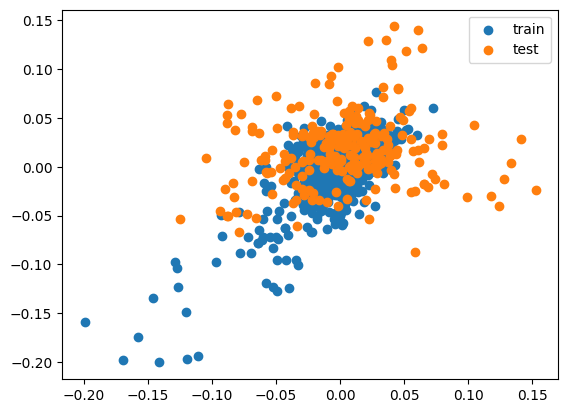

In [35]:
from sklearn.metrics import r2_score

train_predictions = model.predict(scaled_train_features)
test_predictions = model.predict(scaled_test_features)
print("train score:", r2_score(train_targets, train_predictions))
print("test score:", r2_score(test_targets, test_predictions))

#plot predictions vs actual

plt.scatter(train_predictions, train_targets, label='train')
plt.scatter(test_predictions, test_targets, label='test')
plt.legend()
plt.show()

In [36]:
# Custom Loss Functions

# apply a penalty to incorrect prediction directions
# still use MSE but add a penalty for incorrect direction

import keras.losses
import tensorflow as tf

# create custom loss function
def sign_penalty(y_true, y_pred):
    penalty = 50.0
    direction_wrong = tf.less(tf.multiply(y_true, y_pred), 0)
    error = tf.square(y_true - y_pred)
    penalized_error = tf.where(direction_wrong, penalty * error, error)
    return tf.reduce_mean(penalized_error)

keras.losses.sign_penalty = sign_penalty

# create the model
model_2 = Sequential()
model_2.add(Dense(100, 
                  input_dim=scaled_train_features.shape[1], 
                  activation='relu'))
model_2.add(Dense(20, activation='relu'))
model_2.add(Dense(1, activation='linear'))

model_2.compile(optimizer='adam', loss=sign_penalty)
history = model_2.fit(scaled_train_features, train_targets, epochs=25)

plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()


Epoch 1/25


c:\Users\el1trm\Documents\GitHub\Stock-Price-Prediction\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5590   
Epoch 2/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0925 
Epoch 3/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - loss: 0.0424
Epoch 4/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0333 
Epoch 5/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0289 
Epoch 6/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0236 
Epoch 7/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0275 
Epoch 8/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0165 
Epoch 9/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0163
Epoch 10/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0174
Epoch 11/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0230 
Epoch 12/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0180 
Epoch 13/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0123 
Epoch 14/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0107 
Epoch 15/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0103
Epoch 16/25
43/

(1364, 11) (1364,)
(241, 11) (241,)
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
(1364, 1) (1364,)
(241, 1) (241,)
train score: -0.27534306088967186
test score: -2.3833886931273396


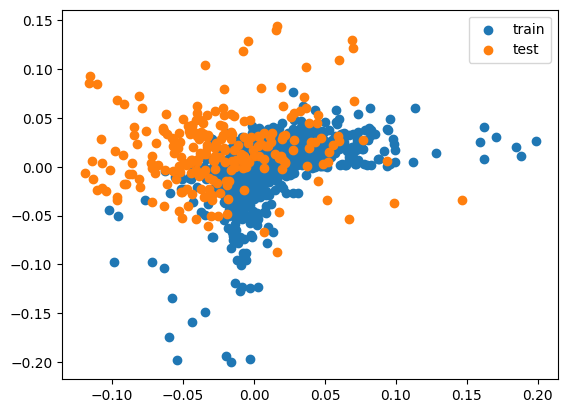

In [37]:
# print out the shapes of these dataframes
print(train_features.shape, train_targets.shape)
print(test_features.shape, test_targets.shape)


# the train_targets and train_predictions have different shapes, so wont be able to calculate the r^2 score
# so we need to reshape them

#train_targets = np.array(train_targets).reshape(-1, 1)
#test_targets = np.array(test_targets).reshape(-1, 1)


train_predictions = model_2.predict(scaled_train_features)
test_predictions = model_2.predict(scaled_test_features)

print(train_predictions.shape, train_targets.shape)
print(test_predictions.shape, test_targets.shape)

print("train score:", r2_score(train_targets, train_predictions))
print("test score:", r2_score(test_targets, test_predictions))

plt.scatter(train_predictions, train_targets, label = 'train')
plt.scatter(test_predictions, test_targets, label = 'test')
plt.legend()
plt.show()

# produces a bow-tie shape, which is what we want

In [38]:
# Overfitting and Ensembling
# drop out to improve overfitting (good on train, bad on test)
# ways to combat overfitting:
#        - decrease model complexity (less layers, less nodes, less trees, etc)
#        - add regularization (L1, L2, etc)
#        - add dropout (randomly drop nodes during training)
#        - autoencoder architecture (use a smaller model to learn the features, then use those features in a larger model)
#        - early stopping (stop training when the validation loss stops improving)
#        - adding noise to data
#        - max norm constraints (limit the weights to a certain range)
#        - Ensemble methods (bagging, boosting, stacking, etc)
#       - cross validation (use different subsets of the data to train and test the model - not possible for this example though)


Epoch 1/25


c:\Users\el1trm\Documents\GitHub\Stock-Price-Prediction\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0989   
Epoch 2/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0220 
Epoch 3/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0136 
Epoch 4/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0089 
Epoch 5/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062 
Epoch 6/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058 
Epoch 7/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0043 
Epoch 8/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0045 
Epoch 9/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033 
Epoch 10/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0031 
Epoch 11/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0025 
Epoch 12/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0023 
Epoch 13/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016     
Epoch 14/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0023 
Epoch 15/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020
Epoch 16/2

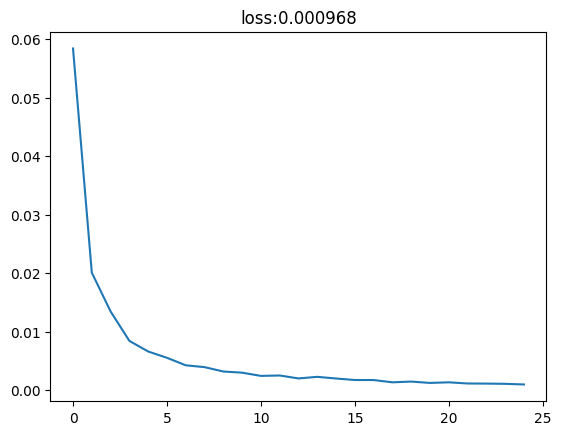

In [39]:
# dropout in keras
from keras.layers import Dropout
model_3 = Sequential()
model_3.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_3.add(Dropout(0.2))  # 20% dropout
model_3.add(Dense(20, activation='relu'))
model_3.add(Dense(1, activation='linear'))

model_3.compile(optimizer='adam', loss='mse')
history = model_3.fit(scaled_train_features, train_targets, epochs=25)
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

In [40]:
# make predictions from the 3 neural network models we now have

train_pred1 = model.predict(scaled_train_features)
test_pred1 = model.predict(scaled_test_features)

train_pred2 = model_2.predict(scaled_train_features)
test_pred2 = model_2.predict(scaled_test_features)

train_pred3 = model_3.predict(scaled_train_features)
test_pred3 = model_3.predict(scaled_test_features)

# Horizontally stack predictions and take the average across rows
train_preds = np.mean(np.hstack((train_pred1, train_pred2, train_pred3)), axis=1)
test_preds = np.mean(np.hstack((test_pred1, test_pred2, test_pred3)), axis=1)

print(test_preds[-5:])

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[-0.01344168 -0.00784012 -0.0078686  -0.01725253 -0.01250431]


In [43]:
# check performance of ensembled model

#evaluate the r^2 scores
print("train score:", r2_score(train_targets, train_preds))
print("test score:", r2_score(test_targets, test_preds))

print(train_preds)

# scatter plot of the predictions vs actual values
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets, label='test')
plt.xlabel("Predicted stock price % change (10 days ahead)")
plt.ylabel("Actual stock price % change (10 days ahead)")
plt.legend()
plt.show()

train score: 0.44515658484889054
test score: -0.3820771915729042
[-0.00463192 -0.01340295 -0.01619213 ... -0.04694594 -0.08432844
 -0.06945557]
